#### Plotting the resulting fits from different MF-112 measurements to predict behavior of thinner/thicker MF-112 samples.

This is using Katie's transfer matrix code from her <code>optlo_calc</code> package

I tried to do simultaneous fitting for different combinations of MF-112a, b, and c but didn't have any luck with using two of them. May try doing a simultaneous fit using all three datasets.

In [3]:
%matplotlib notebook

import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import scipy.optimize as optimize

import optlo_calc as opt
from optlo_calc.material_fitting import *

import astropy.units as u
import astropy.constants as cons

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager

In [4]:
def smooth(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """
    if x.ndim != 1:
        print('smooth only accepts 1 dimension arrays.')
    if x.size < window_len:
        print('Input vector needs to be bigger than window size.')
    if window_len<3:
        return x
    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        print('Window is on of \'flat\', \'hanning\', \'hamming\', \'bartlett\', \'blackman\'')
    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')
    y=np.convolve(w/w.sum(),s,mode='valid')
    return y

In [5]:
MF112a_trans = np.genfromtxt("/data/users/shreyas/final_ndf_files/transmission12deg/t_mf112_hex_12deg_300k_30-300ghz.txt")
MF112a_reflect = np.genfromtxt("/data/users/shreyas/final_ndf_files/reflection2021/mf112_refl_uchi_30-500GHz_300K.txt")

fmax = 300

msk = np.all([ MF112a_reflect[:,0]<= fmax], axis=0)
meas_r_freqs_mf112a = MF112a_reflect[msk,0]
meas_r_mf112a = MF112a_reflect[msk,1]

msk = np.all([ MF112a_trans[:,0]<= fmax], axis=0)

meas_t_freqs_mf112a = MF112a_trans[msk,0]
meas_t_mf112a = MF112a_trans[msk,1]

win=41

meas_r_freqs_smooth_mf112a = smooth(meas_r_freqs_mf112a,win)[win:-win]
meas_r_smooth_mf112a = smooth(meas_r_mf112a,win)[win:-win]
meas_t_freqs_smooth_mf112a = smooth(meas_t_freqs_mf112a,win)[win:-win]
meas_t_smooth_mf112a = smooth(meas_t_mf112a,win)[win:-win]

In [22]:
MF112b_trans = np.genfromtxt("/data/users/shreyas/final_ndf_files/transmission12deg/mf112_ucsd_tm_30-300ghz_300k_20211207.txt")
MF112b_reflect = np.genfromtxt("/data/users/shreyas/final_ndf_files/reflection2021/mf112_refl_ucsd_30-500GHz_300K.txt")

fmax = 300

msk = np.all([ MF112b_reflect[:,0]<= fmax], axis=0)
meas_r_freqs_mf112b = MF112b_reflect[msk,0]
meas_r_mf112b = MF112b_reflect[msk,1]

msk = np.all([ MF112b_trans[:,0]<= fmax], axis=0)

meas_t_freqs_mf112b = MF112b_trans[msk,0]
meas_t_mf112b = MF112b_trans[msk,1]

win=41

meas_r_freqs_smooth_mf112b = smooth(meas_r_freqs_mf112b,win)[win:-win]
meas_r_smooth_mf112b = smooth(meas_r_mf112b,win)[win:-win]
meas_t_freqs_smooth_mf112b = smooth(meas_t_freqs_mf112b,win)[win:-win]
meas_t_smooth_mf112b = smooth(meas_t_mf112b,win)[win:-win]

In [75]:
MF112c_trans = np.genfromtxt("/data/users/shreyas/final_ndf_files/transmission12deg/t_mf112_1in_12deg_300k_30-300ghz.txt")
MF112c_reflect = np.genfromtxt("/data/users/shreyas/final_ndf_files/reflection2021/mf112_refl_ucsd_1inch_30-500GHz_300K.txt")

fmax112c = 300 # was 140

msk = np.all([ MF112c_reflect[:,0]<= fmax112c], axis=0)
meas_r_freqs_mf112c = MF112c_reflect[msk,0]
meas_r_mf112c = MF112c_reflect[msk,1]

msk = np.all([ MF112c_trans[:,0]<= fmax112c], axis=0)

meas_t_freqs_mf112c = MF112c_trans[msk,0]
meas_t_mf112c = MF112c_trans[msk,1]

win=21

meas_r_freqs_smooth_mf112c = smooth(meas_r_freqs_mf112c,win)[win:-win]
meas_r_smooth_mf112c = smooth(meas_r_mf112c,win)[win:-win]
meas_t_freqs_smooth_mf112c = smooth(meas_t_freqs_mf112c,win)[win:-win]
meas_t_smooth_mf112c = smooth(meas_t_mf112c,win)[win:-win]

<IPython.core.display.Javascript object>


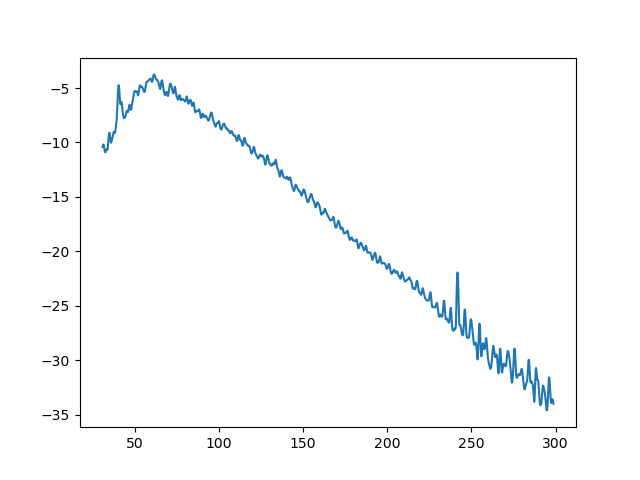

In [42]:
# plt.figure()
# plt.plot(meas_t_freqs_smooth_mf112b, to_dB(meas_t_smooth_mf112b))
# plt.show()

2. Fitting for MF-112c

In [43]:
def ln_like_R(params, constant, ff, R, R_err=None):
    if R_err is None:
        R_err = np.ones_like(R+1)
        
    # extract initial parameter values and constants
    n_real, a, b = params
    tau, nu_0, angle_R, angle_T = constant
    
    # plug into some fitting function?
    model = calc_index_reflection([n_real, nu_0, a, b], ff, thickness = tau, angle = angle_R)
    
    return -0.5 * np.sum((R - model)**2/R_err**2)

def ln_like_T(params, constant, ff, T_dB, T_dB_err = None):
    if T_dB_err is None:
        T_dB_err = np.ones_like(T_dB+1)
        
    # extract initial params and constants
    n_real, a, b = params
    tau, nu_0, angle_R, angle_T = constant
    
    # plug into some fitting function
    model = calc_index_transmission_dB([n_real, nu_0, a, b], ff, thickness = tau, angle = angle_T)
    
    return -0.5 * np.sum( (T_dB - model)**2 / T_dB_err**2)

def combined_like(params, constants, ff_R, R, R_err, ff_T, T, T_dB_err):
    return np.abs(ln_like_R(params, constants, ff_R, R, R_err) + ln_like_T(params, constants, ff_T, T ,T_dB_err))

In [44]:
p0_112 = [2.25, 0.06, 0.4]
v0 = 60

p112a= [2.25409709, 60, 0.04839579, 0.36294532] 
tau112a=6.913*u.mm
constants112a = [tau112a, # thickness ta
                  v0, #pivot freq, GHz
    np.radians(13.5), # reflection
    np.radians(12), # transmission
]

p112b=  [2.33401973, 60, 0.07407253, 0.30854538] 
tau112b=6.7*u.mm
constants112b = [tau112b, # thickness ta
                  v0, #pivot freq, GHz
    np.radians(13.5), # reflection
    np.radians(40), # transmission
]

p112c= [2.2030326, 60, 0.06174298, 0.47407758] 
tau112c=27*u.mm
constants112c = [tau112c, # thickness ta
                  v0, #pivot freq, GHz
    np.radians(13.5), # reflection
    np.radians(40), # transmission
]       

In [45]:
r_err = 0.01
t_err = 0.2 # t_err_db

rmsk = np.all([meas_r_freqs_smooth_mf112c>=60, meas_r_freqs_smooth_mf112c<=300],axis=0)
tmsk = np.all([meas_t_freqs_smooth_mf112c>=60, meas_t_freqs_smooth_mf112c<=140],axis=0)

X = optimize.minimize(combined_like, p0_112, args=(constants112c,
                                              meas_r_freqs_smooth_mf112c[rmsk],
                                              meas_r_smooth_mf112c[rmsk],
                                              np.ones_like(meas_r_smooth_mf112c[rmsk])*r_err,
                                              meas_t_freqs_smooth_mf112c[tmsk],
                                              to_dB(meas_t_smooth_mf112c[tmsk]),
                                              np.ones_like(meas_t_smooth_mf112c[tmsk])*t_err), method = "Nelder-Mead")

In [46]:
print(X.x)
new_mf112c_fit_params = list(X.x)
new_mf112c_fit_params.insert(1,v0)
print(new_mf112c_fit_params)

[2.20291167 0.06179585 0.47392623]
[2.2029116716187014, 60, 0.06179585039641032, 0.4739262252179114]


<IPython.core.display.Javascript object>


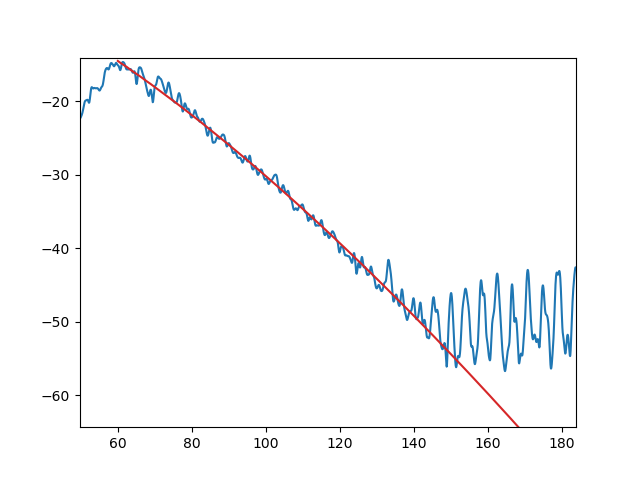

In [47]:
plt.figure()
plt.plot(meas_t_freqs_smooth_mf112c, to_dB(meas_t_smooth_mf112c))
plt.plot(np.linspace(60, 300, 300), to_dB(calc_index_transmission(new_mf112c_fit_params, np.linspace(60, 300, 300), thickness=tau112c,angle = constants112b[3])), color='C3', label="MF-112c")
plt.show()

In [48]:
MF114_trans = np.genfromtxt("/data/users/shreyas/final_ndf_files/transmission12deg/t_mf114_hex_12deg_300k_30-300ghz.txt")
MF114_reflect = np.genfromtxt("/data/users/shreyas/final_ndf_files/reflection2021/mf114_refl_uchi_30-500GHz_300K.txt")

fmax114 = 235

msk = np.all([ MF114_reflect[:,0]<= fmax114], axis=0)
meas_r_freqs_mf114 = MF114_reflect[msk,0]
meas_r_mf114 = MF114_reflect[msk,1]

msk = np.all([ MF114_trans[:,0]<= fmax114], axis=0)

meas_t_freqs_mf114 = MF114_trans[msk,0]
meas_t_mf114 = MF114_trans[msk,1]

win=41

meas_r_freqs_smooth_mf114 = smooth(meas_r_freqs_mf114,win)[win:-win]
meas_r_smooth_mf114 = smooth(meas_r_mf114,win)[win:-win]
meas_t_freqs_smooth_mf114 = smooth(meas_t_freqs_mf114,win)[win:-win]
meas_t_smooth_mf114 = smooth(meas_t_mf114,win)[win:-win]

a. Scale off of the fit for MF-112c

<IPython.core.display.Javascript object>


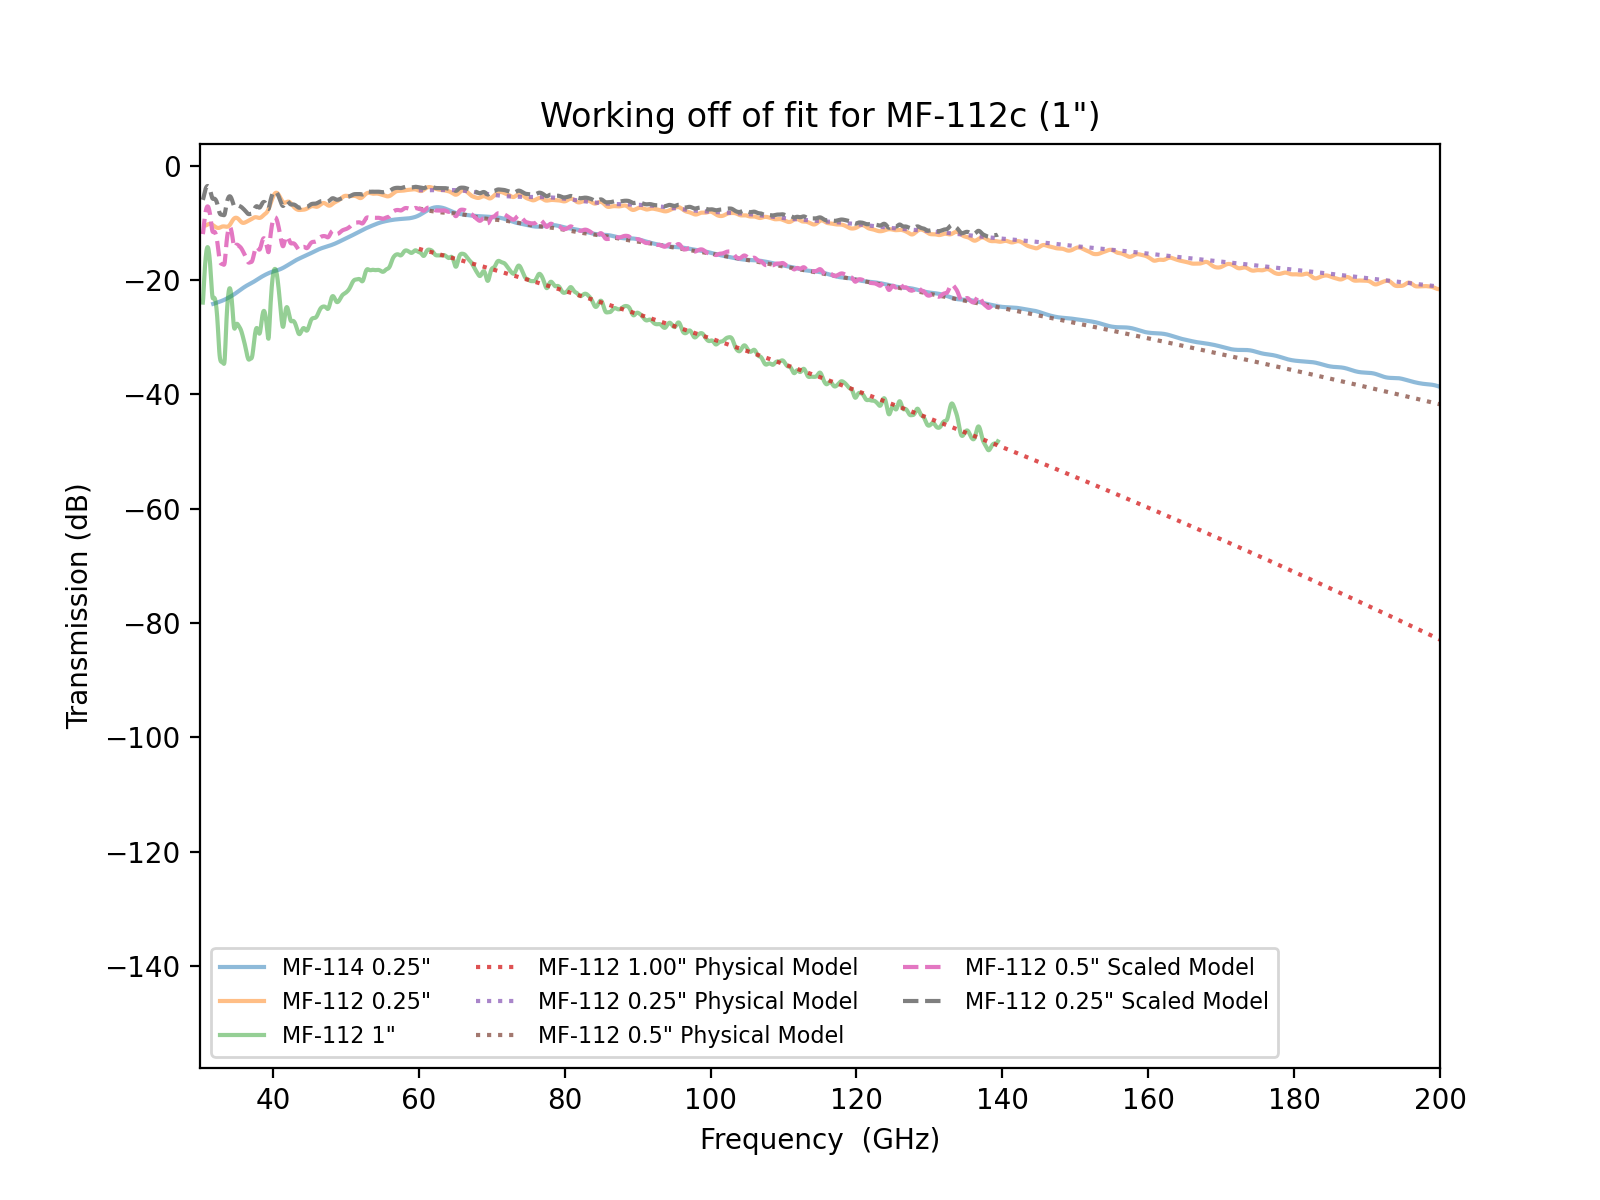

In [106]:
plt.figure(figsize=(8,6))
# the three measured
plt.plot(meas_t_freqs_smooth_mf114, to_dB(meas_t_smooth_mf114), label="MF-114 0.25\"", alpha = 0.5)
plt.plot(meas_t_freqs_smooth_mf112b, to_dB(meas_t_smooth_mf112b), label='MF-112 0.25\"', alpha = 0.5)
plt.plot(meas_t_freqs_smooth_mf112c, to_dB(meas_t_smooth_mf112c),label='MF-112 1\"', alpha = 0.5)

# the three physical models (0.25", 1", 0.5")
plt.plot(np.linspace(60, 300, 300), to_dB(calc_index_transmission(new_mf112c_fit_params, np.linspace(60, 300, 300), thickness=tau112c,angle = constants112c[3])), linestyle='dotted', label="MF-112 1.00\" Physical Model", alpha = 0.8)
plt.plot(np.linspace(60, 300, 300), to_dB(calc_index_transmission(new_mf112c_fit_params, np.linspace(60, 300, 300), thickness=tau112c*0.25, angle = constants112c[3])), linestyle='dotted', label="MF-112 0.25\" Physical Model", alpha = 0.8)
plt.plot(np.linspace(60, 300, 300), to_dB(calc_index_transmission(new_mf112c_fit_params, np.linspace(60, 300, 300), thickness=tau112c*0.5, angle = constants112c[3])), linestyle='dotted', label="MF-112 0.5\" Physical Model", alpha = 0.8)

# two scaled models
plt.plot(meas_t_freqs_smooth_mf112c, 0.5*to_dB(meas_t_smooth_mf112c), label='MF-112 0.5\" Scaled Model', linestyle='dashed')
plt.plot(meas_t_freqs_smooth_mf112c, 0.25*to_dB(meas_t_smooth_mf112c), label='MF-112 0.25\" Scaled Model', linestyle='dashed')

# # fitting parameters for MF-112c (1")
# plt.plot(np.linspace(60, 300, 300), to_dB(calc_index_transmission(new_mf112c_fit_params, np.linspace(60, 300, 300), thickness=tau112c,angle = constants112c[3])), color='grey', linestyle='dotted', label="MF-112 1.00\" Physical Model")
# # fitting parameters for MF-112b (0.25")
# plt.plot(np.linspace(60, 300, 300), to_dB(calc_index_transmission(p112b, np.linspace(60, 300, 300), thickness=tau112b,angle = constants112b[3])), color='red', linestyle='dotted', label="MF-112 0.25\" Physical Model")
# # MF-112c fit extrapolated down to 0.5"
# plt.plot(np.linspace(60, 300, 300), to_dB(calc_index_transmission(new_mf112c_fit_params, np.linspace(60, 300, 300), thickness=tau112c*0.25,angle = constants112c[3])), color='C3', linewidth=2,label="")
# # MF-112b fit extrapolated up to 0.5"
# plt.plot(np.linspace(60, 300, 300), to_dB(calc_index_transmission(p112b, np.linspace(60, 300, 300), thickness=tau112b*2,angle = constants112b[3])), color='C3', label="MF-112c")
plt.ylabel("Transmission (dB)")
plt.xlabel("Frequency  (GHz)")
plt.title("Working off of fit for MF-112c (1\")")
plt.xlim(30, 200)
plt.legend(ncol=3, fontsize=8)
plt.show()
plt.savefig("workingo_off_mf112c_1in.png")

b. Scale off of MF-112b

<IPython.core.display.Javascript object>


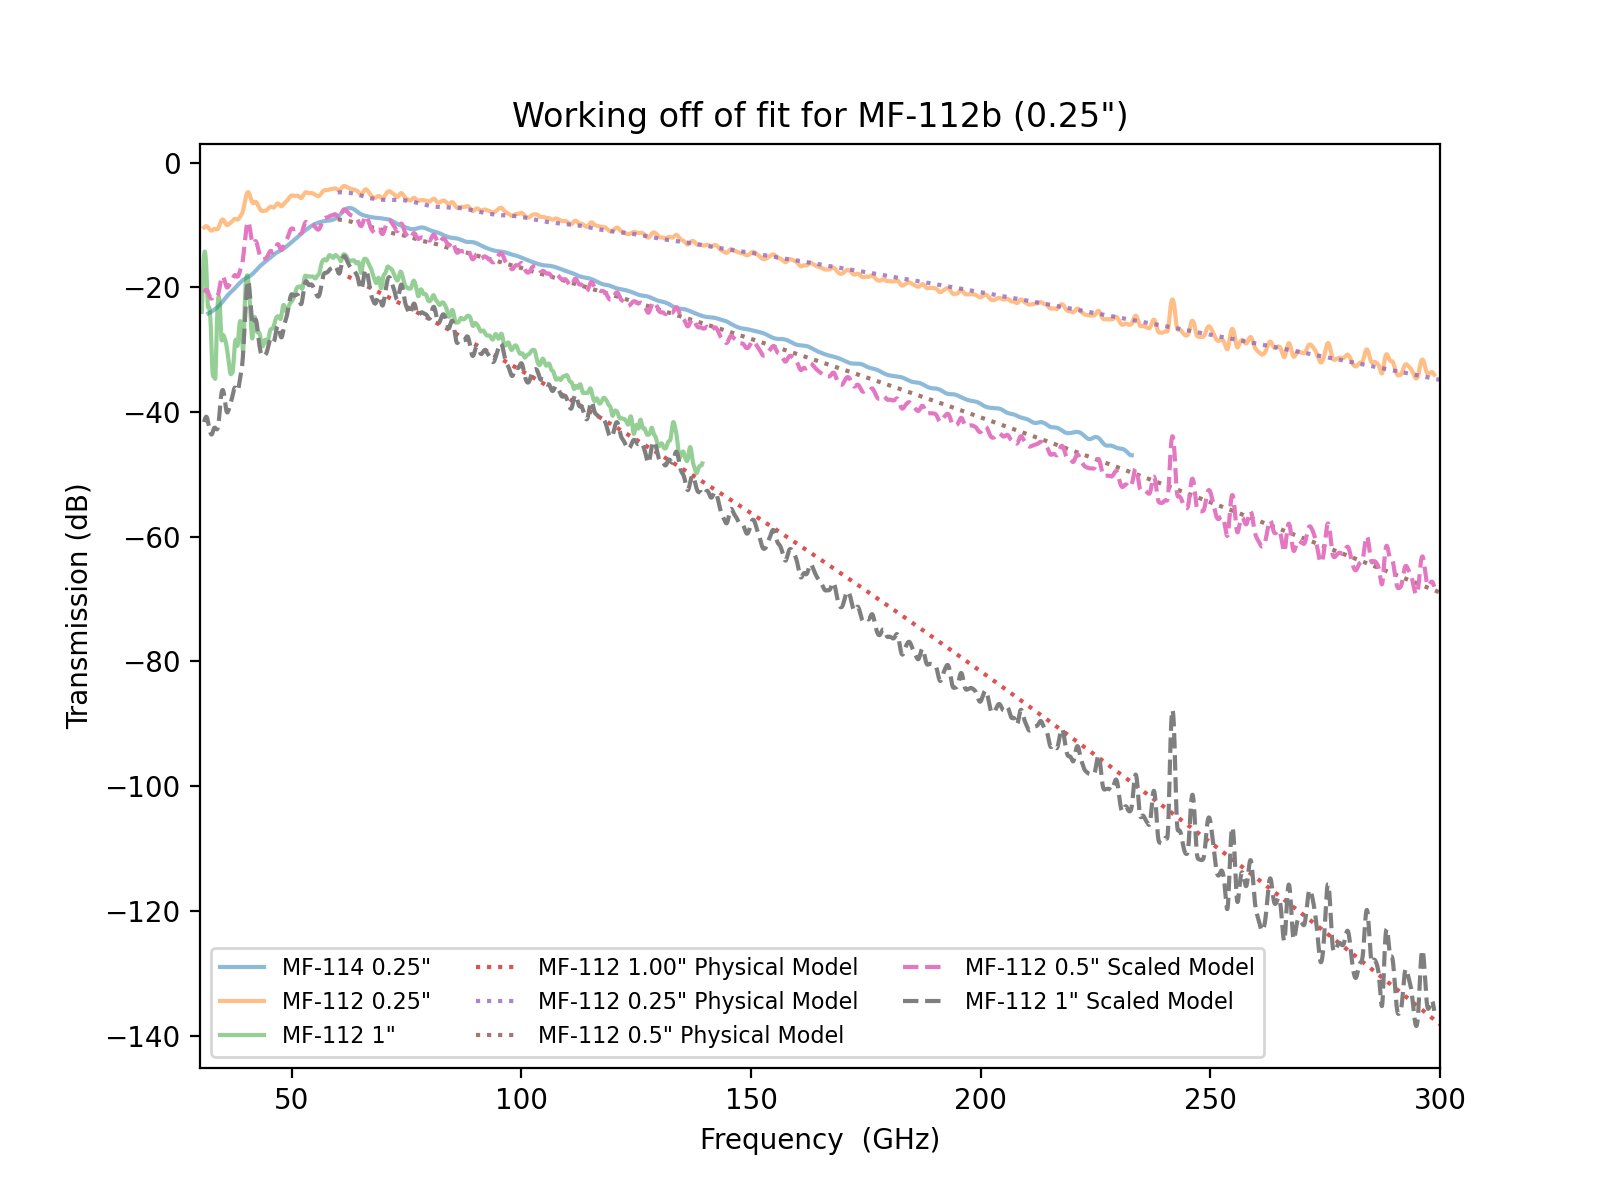

In [107]:
plt.figure(figsize=(8,6))
# the three measured
plt.plot(meas_t_freqs_smooth_mf114, to_dB(meas_t_smooth_mf114), label="MF-114 0.25\"", alpha = 0.5)
plt.plot(meas_t_freqs_smooth_mf112b, to_dB(meas_t_smooth_mf112b), label='MF-112 0.25\"', alpha = 0.5)
plt.plot(meas_t_freqs_smooth_mf112c, to_dB(meas_t_smooth_mf112c),label='MF-112 1\"', alpha = 0.5)

# the three physical models (0.25", 1", 0.5")
plt.plot(np.linspace(60, 300, 300), to_dB(calc_index_transmission(p112b, np.linspace(60, 300, 300), thickness=tau112c,angle = constants112b[3])), linestyle='dotted', label="MF-112 1.00\" Physical Model", alpha = 0.8)
plt.plot(np.linspace(60, 300, 300), to_dB(calc_index_transmission(p112b, np.linspace(60, 300, 300), thickness=tau112b, angle = constants112b[3])), linestyle='dotted', label="MF-112 0.25\" Physical Model", alpha = 0.8)
plt.plot(np.linspace(60, 300, 300), to_dB(calc_index_transmission(p112b, np.linspace(60, 300, 300), thickness=tau112b*2, angle = constants112b[3])), linestyle='dotted', label="MF-112 0.5\" Physical Model", alpha = 0.8)

# two scaled models
plt.plot(meas_t_freqs_smooth_mf112b, 2*to_dB(meas_t_smooth_mf112b), label='MF-112 0.5\" Scaled Model', linestyle='dashed')
plt.plot(meas_t_freqs_smooth_mf112b, 4*to_dB(meas_t_smooth_mf112b), label='MF-112 1\" Scaled Model', linestyle='dashed')

# # fitting parameters for MF-112c (1")
# plt.plot(np.linspace(60, 300, 300), to_dB(calc_index_transmission(new_mf112c_fit_params, np.linspace(60, 300, 300), thickness=tau112c,angle = constants112c[3])), color='grey', linestyle='dotted', label="MF-112 1.00\" Physical Model")
# # fitting parameters for MF-112b (0.25")
# plt.plot(np.linspace(60, 300, 300), to_dB(calc_index_transmission(p112b, np.linspace(60, 300, 300), thickness=tau112b,angle = constants112b[3])), color='red', linestyle='dotted', label="MF-112 0.25\" Physical Model")
# # MF-112c fit extrapolated down to 0.5"
# plt.plot(np.linspace(60, 300, 300), to_dB(calc_index_transmission(new_mf112c_fit_params, np.linspace(60, 300, 300), thickness=tau112c*0.25,angle = constants112c[3])), color='C3', linewidth=2,label="")
# # MF-112b fit extrapolated up to 0.5"
# plt.plot(np.linspace(60, 300, 300), to_dB(calc_index_transmission(p112b, np.linspace(60, 300, 300), thickness=tau112b*2,angle = constants112b[3])), color='C3', label="MF-112c")
plt.ylabel("Transmission (dB)")
plt.xlabel("Frequency  (GHz)")
plt.title("Working off of fit for MF-112b (0.25\")")
plt.xlim(30, 300)
plt.legend(ncol=3, fontsize=8)
plt.show()
plt.savefig("workingo_off_mf112b_0p25in.png")

c. Scale off of MF-112a

<IPython.core.display.Javascript object>


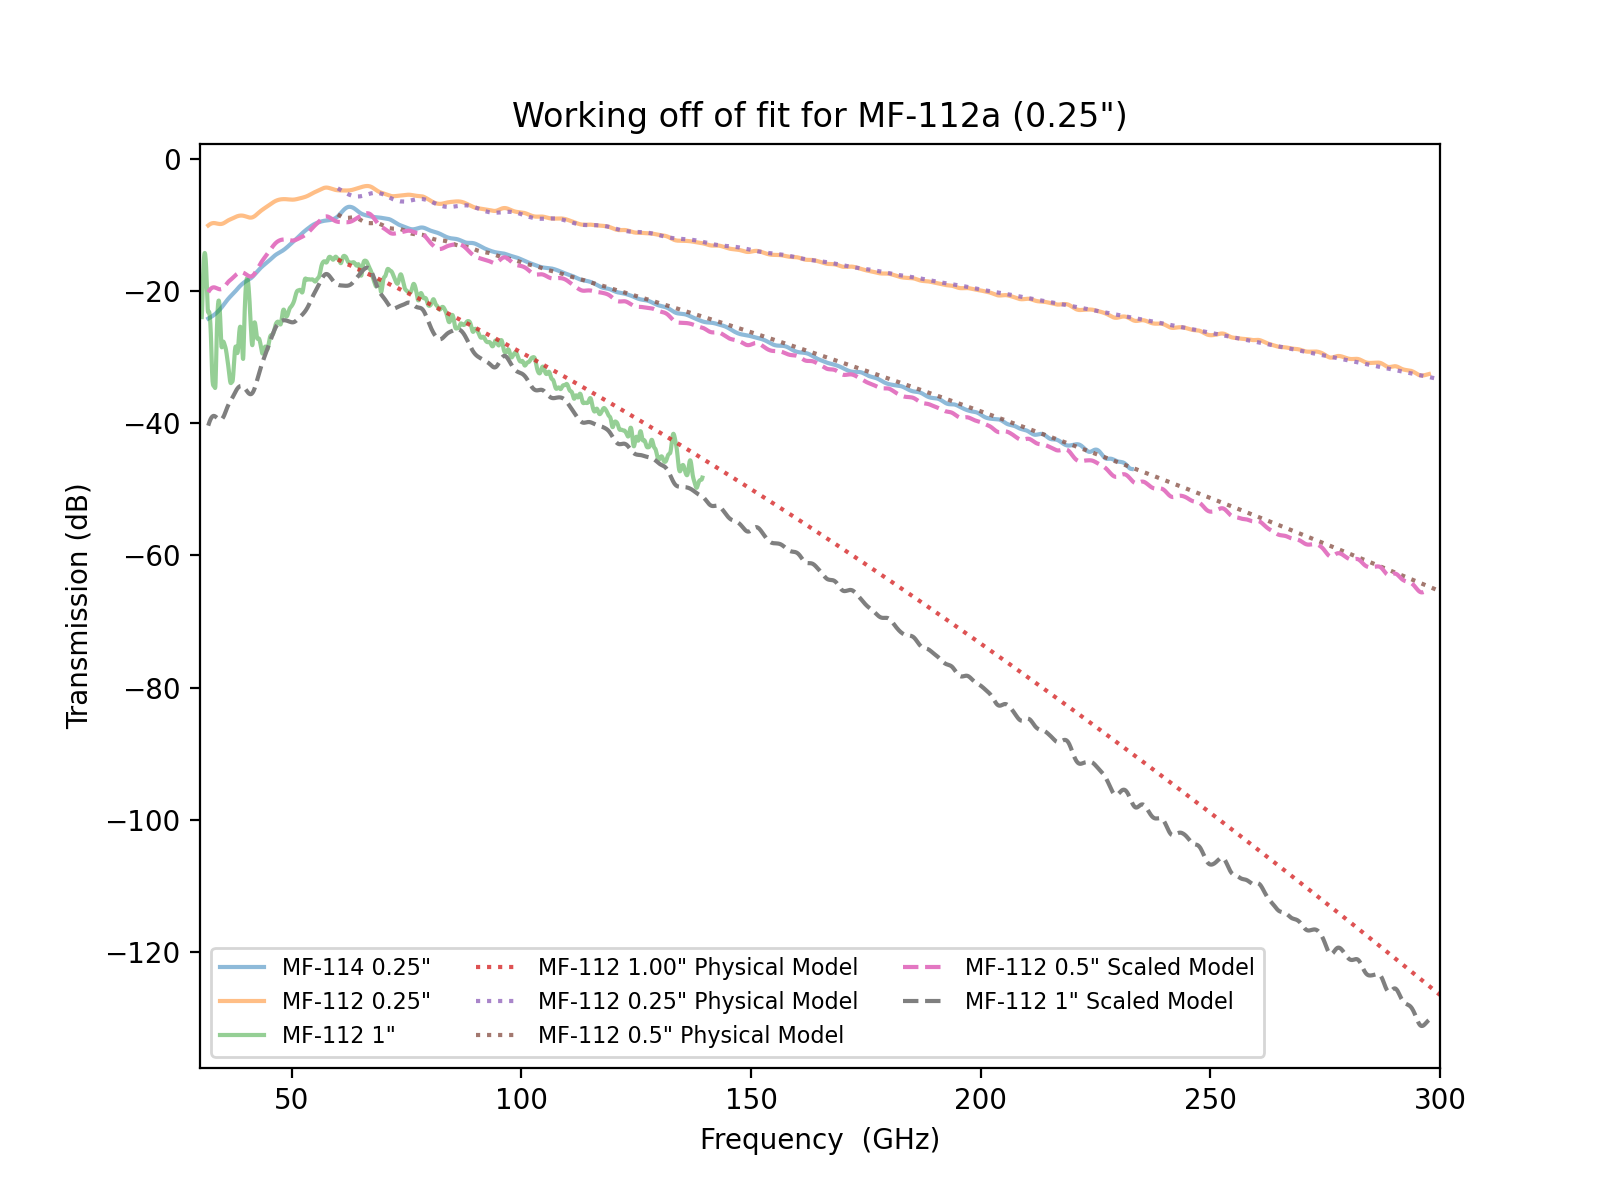

In [108]:
plt.figure(figsize=(8,6))
# the three measured
plt.plot(meas_t_freqs_smooth_mf114, to_dB(meas_t_smooth_mf114), label="MF-114 0.25\"", alpha = 0.5)
plt.plot(meas_t_freqs_smooth_mf112a, to_dB(meas_t_smooth_mf112a), label='MF-112 0.25\"', alpha = 0.5)
plt.plot(meas_t_freqs_smooth_mf112c, to_dB(meas_t_smooth_mf112c),label='MF-112 1\"', alpha = 0.5)

# the three physical models (0.25", 1", 0.5")
plt.plot(np.linspace(60, 300, 300), to_dB(calc_index_transmission(p112a, np.linspace(60, 300, 300), thickness=tau112c,angle = constants112a[3])), linestyle='dotted', label="MF-112 1.00\" Physical Model", alpha = 0.8)
plt.plot(np.linspace(60, 300, 300), to_dB(calc_index_transmission(p112a, np.linspace(60, 300, 300), thickness=tau112a, angle = constants112a[3])), linestyle='dotted', label="MF-112 0.25\" Physical Model", alpha = 0.8)
plt.plot(np.linspace(60, 300, 300), to_dB(calc_index_transmission(p112a, np.linspace(60, 300, 300), thickness=tau112a*2, angle = constants112a[3])), linestyle='dotted', label="MF-112 0.5\" Physical Model", alpha = 0.8)
# two scaled models
plt.plot(meas_t_freqs_smooth_mf112a, 2*to_dB(meas_t_smooth_mf112a), label='MF-112 0.5\" Scaled Model', linestyle='dashed')
plt.plot(meas_t_freqs_smooth_mf112a, 4*to_dB(meas_t_smooth_mf112a), label='MF-112 1\" Scaled Model', linestyle='dashed')

# # fitting parameters for MF-112c (1")
# plt.plot(np.linspace(60, 300, 300), to_dB(calc_index_transmission(new_mf112c_fit_params, np.linspace(60, 300, 300), thickness=tau112c,angle = constants112c[3])), color='grey', linestyle='dotted', label="MF-112 1.00\" Physical Model")
# # fitting parameters for MF-112b (0.25")
# plt.plot(np.linspace(60, 300, 300), to_dB(calc_index_transmission(p112b, np.linspace(60, 300, 300), thickness=tau112b,angle = constants112b[3])), color='red', linestyle='dotted', label="MF-112 0.25\" Physical Model")
# # MF-112c fit extrapolated down to 0.5"
# plt.plot(np.linspace(60, 300, 300), to_dB(calc_index_transmission(new_mf112c_fit_params, np.linspace(60, 300, 300), thickness=tau112c*0.25,angle = constants112c[3])), color='C3', linewidth=2,label="")
# # MF-112b fit extrapolated up to 0.5"
# plt.plot(np.linspace(60, 300, 300), to_dB(calc_index_transmission(p112b, np.linspace(60, 300, 300), thickness=tau112b*2,angle = constants112b[3])), color='C3', label="MF-112c")
plt.ylabel("Transmission (dB)")
plt.xlabel("Frequency  (GHz)")
plt.title("Working off of fit for MF-112a (0.25\")")
plt.xlim(30, 300)
plt.legend(ncol=3, fontsize=8)
plt.show()
plt.savefig("workingo_off_mf112a_0p25in.png")